<a href="https://colab.research.google.com/github/Mubashir21/Liver-Ablation-Simulation-NN/blob/main/model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install neuraloperator
!pip install tensorly
!pip install tensorly-torch
!pip install wandb
!pip install zarr
!pip install torch-harmonics

In [ ]:
from scipy.io import loadmat
import pandas as pd
import torch
from torch import nn
import numpy as np
from neuralop.models import FNO

In [ ]:
data1=loadmat("/content/drive/MyDrive/data_SEGP/CASE01_DATA.mat")
data1["T405"], len(data1.keys())

(array([[63.23 , 63.272, 63.396, ..., 63.396, 63.272, 63.23 ],
        [63.188, 63.229, 63.353, ..., 63.353, 63.229, 63.188],
        [63.063, 63.103, 63.226, ..., 63.226, 63.103, 63.063],
        ...,
        [37.017, 37.017, 37.017, ..., 37.017, 37.017, 37.017],
        [37.008, 37.008, 37.009, ..., 37.009, 37.008, 37.008],
        [37.   , 37.   , 37.   , ..., 37.   , 37.   , 37.   ]]),
 103)

In [ ]:
del data1["__header__"]
del data1["__version__"]
del data1["__globals__"]

In [ ]:
# train_split = round()
data1_1 = []
for count, time in enumerate(data1):
    data_sample = data1[time].tolist()
    if (count == 1):
        data_sample[0].pop(0)
        np_sample = np.array(data_sample).reshape((101, 101)).T
        data_sample = np_sample.tolist()
    elif (count == 99):
        np_sample = np.array(data_sample).reshape((101, 101)).T
        data_sample = np_sample.tolist()
    data1_1.append(data_sample)

data1_1 = np.array(data1_1)

T495


(-0.5, 100.5, 100.5, -0.5)

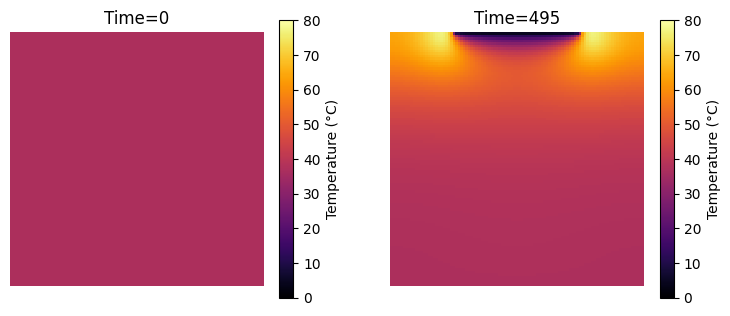

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9, 9))
vmin = 0  # Minimum temperature value
vmax = 80  # Maximum temperature value

fig.add_subplot(1, 2, 1)
sample1 = 0
plt.title(f"Time={sample1 * 5}")
heatmap = plt.imshow(data1_1[sample1], cmap='inferno', interpolation='nearest')
plt.colorbar(label='Temperature (°C)', shrink=0.4)
heatmap.set_clim(vmin, vmax)  # Set the colorbar scale explicitly
plt.axis(False)

fig.add_subplot(1, 2, 2)
sample2 = 99
plt.title(f"Time={sample2 * 5}")
heatmap = plt.imshow(data1_1[sample2], cmap='inferno', interpolation='nearest')
plt.colorbar(label='Temperature (°C)', shrink=0.4)
heatmap.set_clim(vmin, vmax)  # Set the colorbar scale explicitly
plt.axis(False)

In [ ]:
train_split = round(0.8 * len(data1_1))

data_train = data1_1[:train_split]
data_test = data1_1[train_split:]
len(data_train), len(data_test)

(80, 20)

In [ ]:
X_train = []
y_train = []

X_test = []
y_test = []

for i in range(len(data_train) - 1):
    X_train.append(data_train[i])
    y_train.append(data_train[i+1])
for i in range(len(data_test) - 1):
    X_test.append(data_train[i])
    y_test.append(data_train[i+1])
len(X_train), len(y_train), len(X_test), len(y_test)

(79, 79, 19, 19)

In [ ]:
# Convert lists of NumPy arrays to a single NumPy array
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Convert NumPy arrays to PyTorch tensors
X_train = torch.tensor(X_train).unsqueeze(1).to(torch.float)
X_test = torch.tensor(X_test).unsqueeze(1).to(torch.float)
y_train = torch.tensor(y_train).unsqueeze(1).to(torch.float)
y_test = torch.tensor(y_test).unsqueeze(1).to(torch.float)

X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train[0]

(torch.Size([79, 1, 101, 101]),
 torch.Size([19, 1, 101, 101]),
 torch.Size([79, 1, 101, 101]),
 torch.Size([19, 1, 101, 101]),
 tensor([[[37., 37., 37.,  ..., 37., 37., 37.],
          [37., 37., 37.,  ..., 37., 37., 37.],
          [37., 37., 37.,  ..., 37., 37., 37.],
          ...,
          [37., 37., 37.,  ..., 37., 37., 37.],
          [37., 37., 37.,  ..., 37., 37., 37.],
          [37., 37., 37.,  ..., 37., 37., 37.]]]))

In [ ]:
def plotImage(x, index, message):
    # plt.title(f"Time={sample1 * 5}")?
    heatmap = plt.imshow(x, cmap='inferno', interpolation='nearest')
    plt.colorbar(label='Temperature (°C)')
    heatmap.set_clim(vmin, vmax)  # Set the colorbar scale explicitly
    plt.axis(False)
    plt.title(f"{message} at time={(79 + index) * 5}")

In [ ]:
class SpectralConv2d(nn.Module):
    def __init__(self,
                 in_channels,   # Number of input channels
                 out_channels,  # Number of output channels
                 modes1,        # Number of Fourier modes to multiply in the first dimension
                 modes2):       # Number of Fourier modes to multiply in the second dimension
        super(SpectralConv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

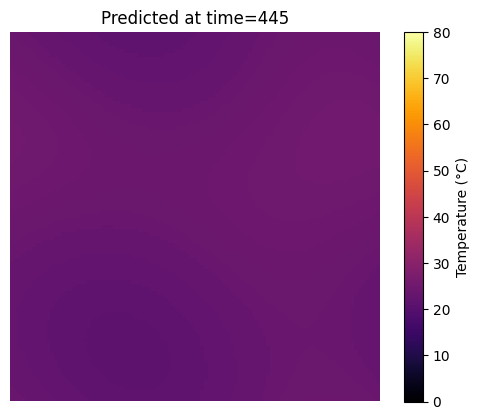

In [ ]:
model2 = SpectralConv2d(1, 1, 1, 2)
sample = X_train[1]
pred = model2.forward(X_test)
pred = pred.detach().numpy()
plotImage(pred[10].squeeze(), 10, "Predicted")

In [ ]:
class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 1, kernel_size=3, padding=1),
            # nn.Sigmoid()  # Use sigmoid activation for pixel values in the range [0, 1]
        )

    def forward(self, x):
        # Encoder
        x = self.encoder(x)

        # Decoder
        x = self.decoder(x)

        return x

In [ ]:
model1 = Model1()
# y_preds[0:5]
# plotImage(output.squeeze())

In [ ]:
from neuralop import LpLoss, H1Loss

loss_fn = LpLoss(d=2, p=2)
# loss_fn = H1Loss(d=2)

# loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model2.parameters(), lr=0.01)

In [ ]:
#MODEL NO Training

epochs = 100

for epoch in range(epochs):
    model2.train()

    y_pred = model2(X_train)

    loss = loss_fn(y_pred, y_train)
    # acc = acc_fn(y_preds, y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if epoch % 5 == 0:
        model2.eval()
        with torch.inference_mode():
            test_pred = model2(X_test)

        test_loss = loss_fn(test_pred, y_test)
        # test_acc = acc_fn(test_pred, y_test)
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch: 0 | Loss: 33.23783 | Test Loss: 7.57715
Epoch: 5 | Loss: 29.61799 | Test Loss: 6.67597
Epoch: 10 | Loss: 26.08500 | Test Loss: 5.78948
Epoch: 15 | Loss: 22.68465 | Test Loss: 4.92715
Epoch: 20 | Loss: 19.48907 | Test Loss: 4.10502
Epoch: 25 | Loss: 16.61205 | Test Loss: 3.35102
Epoch: 30 | Loss: 14.22184 | Test Loss: 2.71221
Epoch: 35 | Loss: 12.51880 | Test Loss: 2.25541
Epoch: 40 | Loss: 11.61540 | Test Loss: 2.02969
Epoch: 45 | Loss: 11.35357 | Test Loss: 1.98913
Epoch: 50 | Loss: 11.35722 | Test Loss: 2.01282
Epoch: 55 | Loss: 11.34041 | Test Loss: 2.02032
Epoch: 60 | Loss: 11.23432 | Test Loss: 2.00048
Epoch: 65 | Loss: 11.09430 | Test Loss: 1.97366
Epoch: 70 | Loss: 10.98316 | Test Loss: 1.95712
Epoch: 75 | Loss: 10.91731 | Test Loss: 1.95256
Epoch: 80 | Loss: 10.87733 | Test Loss: 1.95242
Epoch: 85 | Loss: 10.84166 | Test Loss: 1.95065
Epoch: 90 | Loss: 10.80377 | Test Loss: 1.94649
Epoch: 95 | Loss: 10.76743 | Test Loss: 1.94190


In [ ]:
# #MODEL CNN Training

# epochs = 20

# for epoch in range(epochs):
#     model1.train()

#     y_pred = model1(X_train)

#     loss = loss_fn(y_pred, y_train)
#     # acc = acc_fn(y_preds, y_train)

#     optimizer.zero_grad()

#     loss.backward()

#     optimizer.step()

#     if epoch % 5 == 0:
#         model1.eval()
#         with torch.inference_mode():
#             test_pred = model1(X_test)

#         test_loss = loss_fn(test_pred, y_test)
#         # test_acc = acc_fn(test_pred, y_test)
#         print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

In [ ]:
with torch.inference_mode():
    y_preds = model2(X_test)

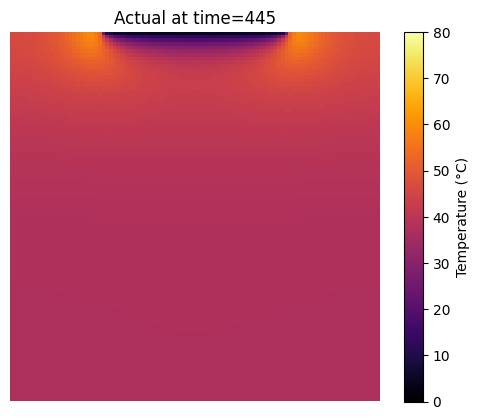

In [ ]:
plotImage(y_test[10].squeeze().numpy(), 10, "Actual")

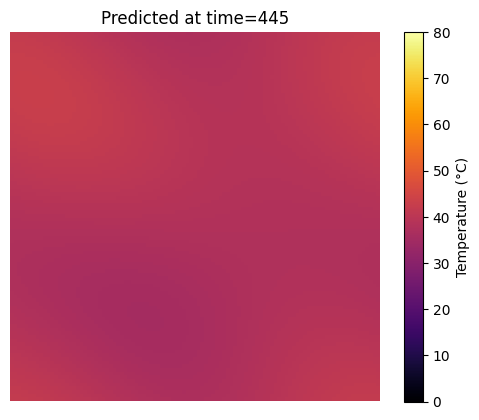

In [ ]:
plotImage(y_preds[10].squeeze().numpy(), 10, "Predicted")
# y_preds[4][0][80][30], y_test[4][0][80][30]

In [ ]:
!git add .

error: open("drive/MyDrive/ACE - Semester 2.gdoc"): Operation not supported
error: unable to index file 'drive/MyDrive/ACE - Semester 2.gdoc'
fatal: adding files failed
